In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats



import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [4]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R60D05LexA_jGCaMP7b_CsChrimsontdT_EL_hcKCR1')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df = sess_df.iloc[:-1]
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['condition'] for _, row in sess_df.iterrows()]
sess_df['mean offset'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['offset var.'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['mean vec. len'] = [np.nan for _, row in sess_df.iterrows()]


figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/R60D05LexA_jGCaMP7b_CsChrimsontdT_EL_hcKCR1')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]

Index(['date', 'fly', 'sess', 'condition', 'scan_type', 'usable', 'notes'], dtype='object')


# Show opto response is similar across hcKCR1 flies and UAS control flies

In [26]:
def get_opto_resp(pp):
    time = pp.voltage_recording_aligned['Time(ms)']
    opto_trig = pp.voltage_recording_aligned[' Opto Trigger']



    opto_trig_bool = np.concatenate([[0],np.diff((1*(opto_trig>1000)))>0])>0
    opto_inds = np.argwhere(opto_trig_bool).flatten()


    volume_dt = np.diff(np.array(pp.metadata['frame_times']),axis=0)[0,0]    
    
    n_frames = int(pp.metadata['mark_points']['duration']/1000/volume_dt)
    opto_off_inds = opto_inds + n_frames

    for ind in opto_inds:
        pp.timeseries['rois'][:,:,ind:ind+n_frames-1] = np.nan
    pp.timeseries['rois'][:,:,:int(2/volume_dt)]=np.nan
    dff = pp.calculate_zscored_F('rois', exp_detrend=False, zscore=True, background_ts='background')[-1,:,:]
    
    
    
    n_rois, n_points, n_reps, n_frames = dff.shape[0], 8, 5, 2
    opto_resp = np.zeros((n_rois, n_points, n_reps))

    assert n_points*n_reps == len(opto_off_inds), "wrong number of opto inds"
    mp = 0
    for rep in range(n_reps):
        for point in range(n_points):
            ind = opto_off_inds[mp]
           
            opto_resp[:,point,rep] = np.nanmean(dff[:,ind:ind+3],axis=-1)
            mp+=1
            
    return opto_resp

def load_row(row):
    outdir = pathlib.PurePath( basedir / row['condition'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)

In [27]:
opto_responses = {
    'remap_0deg': {'uas_control': [], 'hckcr1': []},
    'remap_180deg': {'uas_control': [], 'hckcr1': []}
}

sess_df_remap0 = sess_df.loc[sess_df['scan_type']=='remap_0deg']
hckcr1 = sess_df_remap0.loc[sess_df_remap0['condition']=='hckcr1']
opto_responses['remap_0deg']['hckcr1'] = np.stack([get_opto_resp(load_row(row)) for _, row in hckcr1.iterrows()])

uas_control = sess_df_remap0.loc[sess_df_remap0['condition']=='uas_control']
opto_responses['remap_0deg']['uas_control'] = np.stack([get_opto_resp(load_row(row)) for _, row in uas_control.iterrows()]) 

sess_df_remap180 = sess_df.loc[sess_df['scan_type']=='remap_180deg']
hckcr1 = sess_df_remap180.loc[sess_df_remap180['condition']=='hckcr1']
opto_responses['remap_180deg']['hckcr1'] = np.stack([get_opto_resp(load_row(row)) for _, row in hckcr1.iterrows()]) 

uas_control = sess_df_remap180.loc[sess_df_remap180['condition']=='uas_control']
opto_responses['remap_180deg']['uas_control'] = np.stack([get_opto_resp(load_row(row)) for _, row in uas_control.iterrows()])   




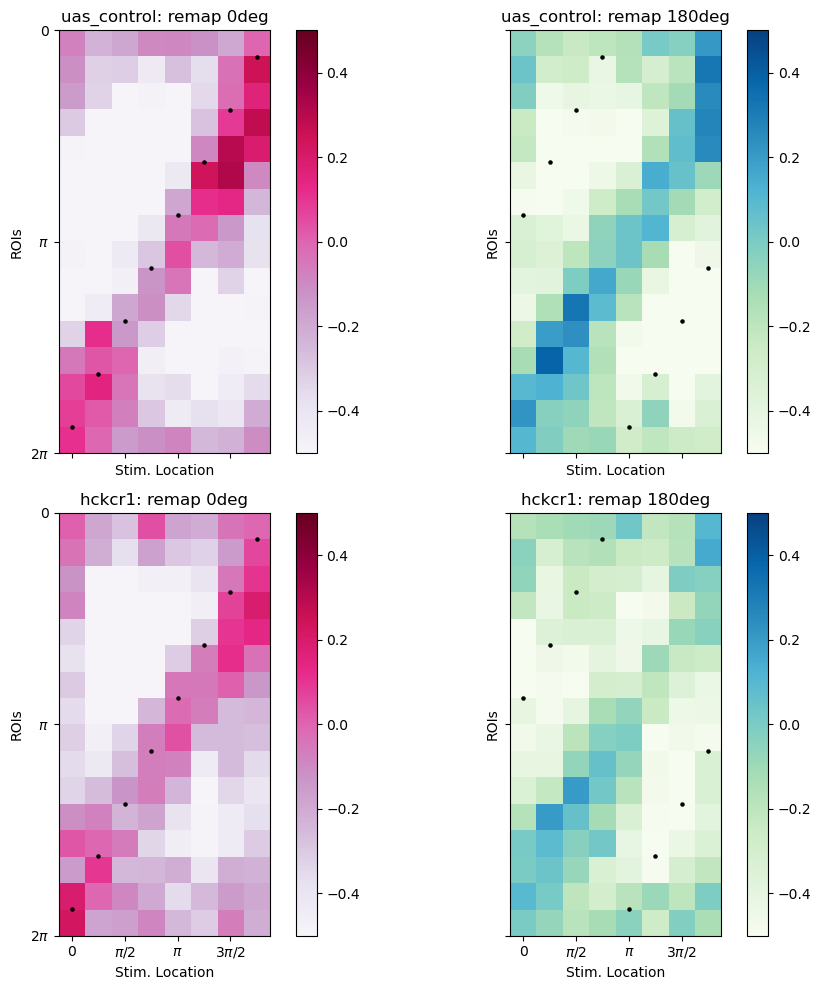

In [28]:
fig, ax = plt.subplots(2,2,figsize=[10,10],sharex=True,sharey=True)
h = ax[0,0].imshow(np.nanmean(opto_responses['remap_0deg']['uas_control'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[0,0])
h = ax[0,1].imshow(np.nanmean(opto_responses['remap_180deg']['uas_control'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[0,1])



h = ax[1,0].imshow(np.nanmean(opto_responses['remap_0deg']['hckcr1'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[1,0])
h = ax[1,1].imshow(np.nanmean(opto_responses['remap_180deg']['hckcr1'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[1,1])



ax[0,0].set_title('uas_control: remap 0deg')
ax[0,1].set_title('uas_control: remap 180deg')
ax[1,0].set_title('hckcr1: remap 0deg')
ax[1,1].set_title('hckcr1: remap 180deg')

for r in range(2):
    x = np.arange(8)
    y = np.arange(0,2*np.pi,np.pi/4)[::-1]*8/np.pi+.5
    h = ax[r,0].scatter(x,y,color= 'black',s=5, label='stim location')


    y = np.roll(y,4)
    ax[r,1].scatter(x,y,color='black',s=5)
    

for a in ax.flatten():
    a.set_ylabel('ROIs')
    a.set_xlabel('Stim. Location')
    
    a.set_xticks([0,2,4,6], labels=[r'0',r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([-.5,7.5,15.5], labels=[r'0',r'$\pi$', r'2$\pi$'])
fig.tight_layout()

Text(0, 0.5, 'Z-scored F (180 deg)')

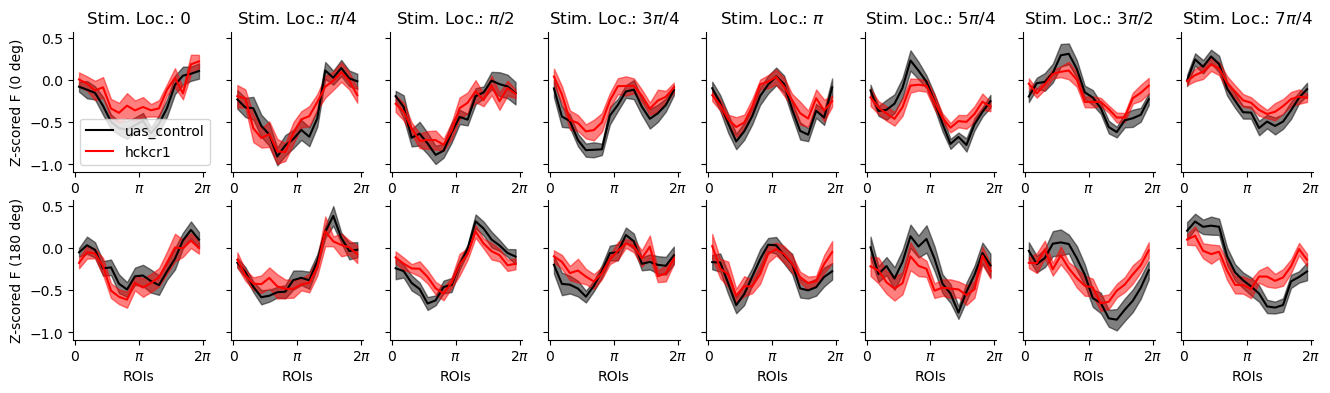

In [29]:
fig, ax = plt.subplots(2,8, figsize=[16,4], sharey=True)
x = np.arange(16)

mu, sem = opto_responses['remap_0deg']['uas_control'].mean(axis=(0,3)), sp.stats.sem(opto_responses['remap_0deg']['uas_control'].mean(axis=3),axis=0)
for i in range(8):
    ax[0,i].plot(x,mu[:,i],color='black', label='uas_control')
    ax[0,i].fill_between(x,mu[:,i]-sem[:,i],mu[:,i]+sem[:,i],alpha=.5, color='black')
    
mu, sem = opto_responses['remap_0deg']['hckcr1'].mean(axis=(0,3)), sp.stats.sem(opto_responses['remap_0deg']['hckcr1'].mean(axis=3),axis=0)
for i in range(8):
    ax[0,i].plot(x,mu[:,i],color='red', label='hckcr1')
    ax[0,i].fill_between(x,mu[:,i]-sem[:,i],mu[:,i]+sem[:,i],alpha=.5, color='red')
    
ax[0,0].legend()
mu, sem = opto_responses['remap_180deg']['uas_control'].mean(axis=(0,3)), sp.stats.sem(opto_responses['remap_180deg']['uas_control'].mean(axis=3),axis=0)
for i in range(8):
    ax[1,i].plot(x,mu[:,i],color='black')
    ax[1,i].fill_between(x,mu[:,i]-sem[:,i],mu[:,i]+sem[:,i],alpha=.5, color='black')
    
mu, sem = opto_responses['remap_180deg']['hckcr1'].mean(axis=(0,3)), sp.stats.sem(opto_responses['remap_180deg']['hckcr1'].mean(axis=3),axis=0)
for i in range(8):
    ax[1,i].plot(x,mu[:,i],color='red')
    ax[1,i].fill_between(x,mu[:,i]-sem[:,i],mu[:,i]+sem[:,i],alpha=.5, color='red')

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xticks([-.5,7.5,15.5], labels=[r'0',r'$\pi$', r'2$\pi$'])
    a.set_xlabel('ROIs')
    # a.set_ylabel('Z-scored F')
stim_locations = ['0', r'$\pi$/4', r'$\pi$/2', r'3$\pi$/4', r'$\pi$', r'5$\pi$/4',  r'3$\pi$/2', r'7$\pi$/4']
for i in range(8):
    ax[0,i].set_title(f'Stim. Loc.: {stim_locations[i]}')    

ax[0,0].set_ylabel('Z-scored F (0 deg)')
ax[1,0].set_ylabel('Z-scored F (180 deg)')


1.282261858584098 0.2115140007894136


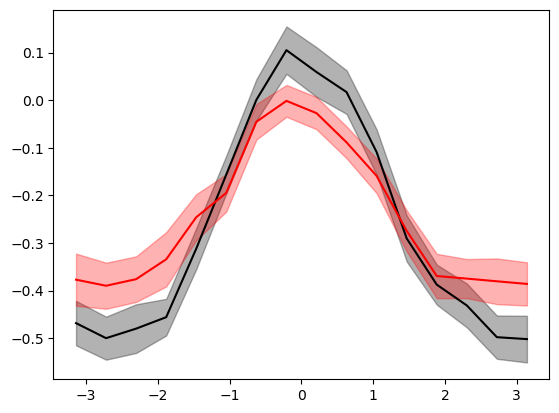

In [33]:

opto_resp_al = {}
for rk in ('remap_0deg', 'remap_180deg'):
    opto_resp_al[rk] = {}
    for ck in ('uas_control', 'hckcr1'):
        opto = np.copy(opto_responses[rk][ck])
        
        for i in range(8):
            opto[:,:,i,:] = np.roll(opto[:,:,i,:],2*i-8, axis=1)
            
        opto_resp_al[rk][ck] = opto
        

fig, ax = plt.subplots()
uas_resp = np.stack((opto_resp_al['remap_0deg']['uas_control'].mean(axis=(2,3)), opto_resp_al['remap_180deg']['uas_control'].mean(axis=(2,3)))).mean(axis=0)
hckcr1_resp = np.stack((opto_resp_al['remap_0deg']['hckcr1'].mean(axis=(2,3)), opto_resp_al['remap_180deg']['hckcr1'].mean(axis=(2,3)))).mean(axis=0)

x = np.linspace(-np.pi, np.pi, num=16)
mu, sem = uas_resp.mean(axis=0), sp.stats.sem(uas_resp, axis=0)
ax.plot(x,mu, color='black')
ax.fill_between(x, mu-sem, mu+sem, color='black', alpha=.3)

mu, sem = hckcr1_resp.mean(axis=0), sp.stats.sem(hckcr1_resp, axis=0)
ax.plot(x,mu, color='red')
ax.fill_between(x, mu-sem, mu+sem, color='red', alpha=.3)

# t,p = sp.stats.ttest_ind(uas_resp[:,7:10].mean(axis=-1), hckcr1_resp[:,7:10].mean(axis=-1))
t,p = sp.stats.ttest_ind(np.linalg.norm(uas_resp, axis=-1), np.linalg.norm(hckcr1_resp, axis=-1))
print(t,p)

ax.spines['top'].set_visible(False)

# Summary plots

In [7]:
ts = nmp.session.GetTS(load_row(sess_df.iloc[0])).get_ts()

In [16]:
nonremap_sess_df = sess_df.loc[(sess_df['scan_type']=='baseline') | (sess_df['scan_type']=='post_0deg') | (sess_df['scan_type']=='post_180deg')]
flies = nonremap_sess_df['fly_id'].unique()

for index,row in nonremap_sess_df.iterrows():
    ts = nmp.session.GetTS(load_row(row))
    
    
    offset_c_mu = ts.offset_c.mean()
    
    sess_df.loc[index, 'mean offset'] = np.angle(offset_c_mu)
    sess_df.loc[index, 'mean vec. len'] = np.abs(offset_c_mu)
    sess_df.loc[index, 'offset var.'] = sp.stats.circvar(ts.offset)


In [17]:
fly_sum_stats = {
    'fly_id': [],
    'hckcr1': [],
}

for s in ('baseline', 'post_0deg', 'post_180deg'):
    fly_sum_stats[f'{s} mean offset'] = []
    fly_sum_stats[f'{s} vec. len'] = []
    fly_sum_stats[f'{s} offset var.'] = []
    
for fly in flies:
    fly_sum_stats['fly_id'].append(fly)
    fly_sum_stats['hckcr1'].append('hckcr1' in fly)
    for s in ('baseline', 'post_0deg', 'post_180deg'):
        fly_sum_stats[f'{s} mean offset'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean offset'].mean())
        fly_sum_stats[f'{s} vec. len'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean vec. len'].mean())
        fly_sum_stats[f'{s} offset var.'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['offset var.'].mean())
        
fly_sum_stats = pd.DataFrame(fly_sum_stats)
fly_sum_stats.head()

,fly_id,hckcr1,baseline mean offset,baseline vec. len,baseline offset var.,post_0deg mean offset,post_0deg vec. len,post_0deg offset var.,post_180deg mean offset,post_180deg vec. len,post_180deg offset var.
0,19_11_2024_fly1_hckcr1,True,-0.601212,0.358561,0.641439,-1.058829,0.294721,0.705279,-0.852741,0.327107,0.672893
1,19_11_2024_fly2_hckcr1,True,-2.675262,0.306701,0.693299,-2.362710,0.320310,0.679690,-2.924083,0.326810,0.673190
2,23_11_2024_fly1_hckcr1,True,-0.422394,0.382436,0.617564,-0.412783,0.494464,0.505536,-0.534979,0.330568,0.669432
3,25_11_2024_fly1_hckcr1,True,-0.259795,0.387538,0.612462,-0.666570,0.442909,0.557091,-0.435337,0.382886,0.617114
4,25_11_2024_fly2_hckcr1,True,2.031136,0.198142,0.801858,2.027348,0.391118,0.608882,2.442524,0.347143,0.652857


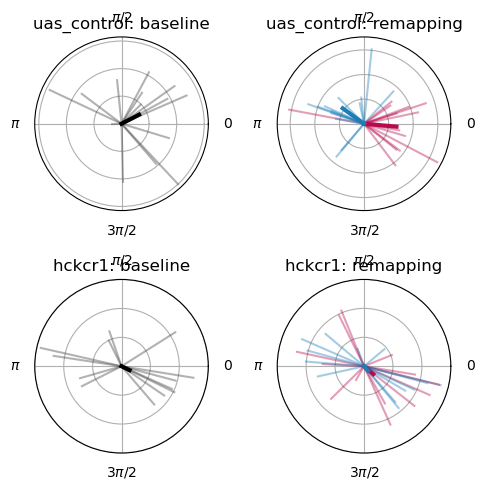

In [18]:
fig, ax = plt.subplots(2, 2, subplot_kw={'projection':'polar'}, figsize=[5,5])

uas_control = fly_sum_stats.loc[fly_sum_stats['hckcr1']==False]
for _, row in uas_control.iterrows():
    ax[0,0].plot(row['baseline mean offset']*np.ones([2,]), [0, row['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4)
    
    ax[0,1].plot(row['post_0deg mean offset']*np.ones([2,]), [0, row['post_0deg vec. len']], color=plt.cm.PuRd(.8), alpha=.4)
    ax[0,1].plot(row['post_180deg mean offset']*np.ones([2,]), [0, row['post_180deg vec. len']], color=plt.cm.GnBu(.8), alpha=.4)

baseline_v = uas_control['baseline vec. len']*(np.cos(uas_control['baseline mean offset'])+1j*np.sin(uas_control['baseline mean offset']))
ax[0,0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=3)

post_0deg_v = uas_control['post_0deg vec. len']*(np.cos(uas_control['post_0deg mean offset'])+1j*np.sin(uas_control['post_0deg mean offset']))
ax[0,1].plot(np.angle(post_0deg_v.mean())*np.ones((2,)), np.absolute(post_0deg_v.mean())*np.array([0,1]), color=plt.cm.PuRd(.8), linewidth=3)

post_180deg_v = uas_control['post_180deg vec. len']*(np.cos(uas_control['post_180deg mean offset'])+1j*np.sin(uas_control['post_180deg mean offset']))
ax[0,1].plot(np.angle(post_180deg_v.mean())*np.ones((2,)), np.absolute(post_180deg_v.mean())*np.array([0,1]), color=plt.cm.GnBu(.8), linewidth=3)
    
hckcr1 = fly_sum_stats.loc[fly_sum_stats['hckcr1']==True]
for _, row in hckcr1.iterrows():
    ax[1,0].plot(row['baseline mean offset']*np.ones([2,]), [0, row['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4)
    
    ax[1,1].plot(row['post_0deg mean offset']*np.ones([2,]), [0, row['post_0deg vec. len']], color=plt.cm.PuRd(.8), alpha=.4)
    ax[1,1].plot(row['post_180deg mean offset']*np.ones([2,]), [0, row['post_180deg vec. len']], color=plt.cm.GnBu(.8), alpha=.4)

baseline_v = hckcr1['baseline vec. len']*(np.cos(hckcr1['baseline mean offset'])+1j*np.sin(hckcr1['baseline mean offset']))
ax[1,0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=3)

post_0deg_v = hckcr1['post_0deg vec. len']*(np.cos(hckcr1['post_0deg mean offset'])+1j*np.sin(hckcr1['post_0deg mean offset']))
ax[1,1].plot(np.angle(post_0deg_v.mean())*np.ones((2,)), np.absolute(post_0deg_v.mean())*np.array([0,1]), color=plt.cm.PuRd(.8), linewidth=3)

post_180deg_v = hckcr1['post_180deg vec. len']*(np.cos(hckcr1['post_180deg mean offset'])+1j*np.sin(hckcr1['post_180deg mean offset']))
ax[1,1].plot(np.angle(post_180deg_v.mean())*np.ones((2,)), np.absolute(post_180deg_v.mean())*np.array([0,1]), color=plt.cm.GnBu(.8), linewidth=3)


for a in ax.flatten():
    a.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([0,.2,.4,.6],['','','',''])
    


ax[0,0].set_title('uas_control: baseline')
ax[0,1].set_title('uas_control: remapping')

ax[1,0].set_title('hckcr1: baseline')
ax[1,1].set_title('hckcr1: remapping')

fig.tight_layout()

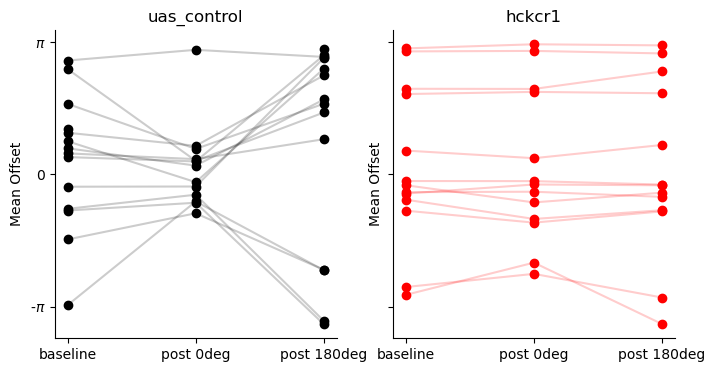

In [19]:
def plot_min_dist(df, h_ax, x=np.arange(3), color='black'):
    for _, row in df.iterrows():
        b = row['baseline mean offset']
        p0 = row['post_0deg mean offset']
        # p180 = row['post_180deg mean offset']
        # _p0 = row['post_0deg mean offset'] 
        # p0 = np.array([_p0, _p0+2*np.pi, _p0-2*np.pi])
        # p0 = p0[np.argmin(np.abs(b-p0))]
        
        _p180 = row['post_180deg mean offset']
        p180 = np.array([_p180, _p180+2*np.pi, _p180-2*np.pi])
        p180 = p180[np.argmin(np.abs(b-p180))]
        
        h_ax.scatter(x, [b,p0,p180], color=color)
        # h_ax.scatter(x, [b,p0,p180], color=plt.cm.hsv((b+np.pi)/(2*np.pi)), alpha=1)
        h_ax.plot(x, [b,p0,p180], color=color, alpha=.2)
    

fig, ax = plt.subplots(1,2, figsize=[8,4], sharex=True, sharey=True)
plot_min_dist(uas_control, ax[0], color='black')
ax[0].set_title('uas_control')
plot_min_dist(hckcr1, ax[1], color='red')
ax[1].set_title('hckcr1')

for a in ax.flatten():
    a.set_xticks([0,1,2], ['baseline', 'post 0deg', 'post 180deg'])
    a.set_yticks([-np.pi,0,np.pi], [r'-$\pi$', '0', r'$\pi$'])
    a.set_ylabel('Mean Offset')
    
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)



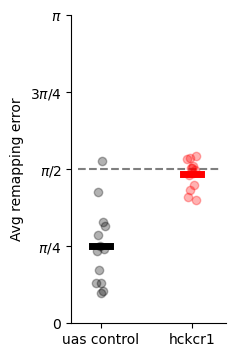

In [20]:
diff0 = np.abs(fly_sum_stats['post_0deg mean offset'] )
diff180 = np.abs(np.pi - fly_sum_stats['post_180deg mean offset'] )
diff180 = np.minimum(diff180, 2*np.pi-diff180)

fly_sum_stats['avg diff'] = (diff0+diff180)/2

fig, ax = plt.subplots(1,1, figsize=[2,4])
n_uas = fly_sum_stats.loc[fly_sum_stats['hckcr1']==False].shape[0]
uas_diff = fly_sum_stats.loc[fly_sum_stats['hckcr1']==False]['avg diff']
ax.scatter(np.linspace(0,.1,num=n_uas), uas_diff, color='black', alpha=.3)
ax.plot([-.05,.15],[np.mean(uas_diff),np.mean(uas_diff)], color='black', linewidth=5)

n_hckcr1 = fly_sum_stats.loc[fly_sum_stats['hckcr1']==True].shape[0]
hckcr1_diff = fly_sum_stats.loc[fly_sum_stats['hckcr1']==True]['avg diff']
ax.scatter(np.linspace(0,.1,num=n_hckcr1)+1, hckcr1_diff, color='red', alpha=.3)
ax.plot([.95,1.15],[np.mean(hckcr1_diff),np.mean(hckcr1_diff)], color='red', linewidth=5)

ax.plot([-.2,1.35], [np.pi/2, np.pi/2], 'k--', alpha=.5, zorder=-1)

ax.set_xticks([.05,1.05], labels=['uas control', 'hckcr1'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Avg remapping error')
_ = ax.set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4, np.pi], labels=[0, r"$\pi$/4", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])


# Plot every session

In [23]:
  
def plot_sess_heatmaps(ts_dict, vmin=-.5, vmax=.5, plot_times = np.arange(0, 180, 60)):
    fig, ax = plt.subplots(3, 2, figsize=[15,6], sharey=True, sharex=True)
    
    
    def get_time_ticks_inds(time, plot_times):
        inds = []
        for t in plot_times:
            inds.append(np.argmin(np.abs(time-t)))
        return inds
        
    
    def plot_row(key, row, cmap):
        dff = ts_dict[key].dff
        time = ts_dict[key].time
        x = np.arange(dff.shape[1])
        heading_ = (ts_dict[key].heading+np.pi)/(2*np.pi)*15
        h = ax[row,0].imshow(dff, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(h, ax=ax[row,0])
        
        ax[row,0].scatter(x, heading_, color='orange', s=5)
        
        h = ax[row,1].imshow(ts_dict[key].dff_h_aligned, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(h, ax=ax[row,1])
        ax[row,1].scatter(x, 7.5*np.ones_like(heading_), color='orange', s=5)
        
        ax[row,0].set_ylabel('ROIs')
        ax[row,0].set_yticks([-0.5,7.5,15.5], labels=[r'0', r'$\pi$', r'$2\pi$'])
        
        ax[row,0].set_xticks(get_time_ticks_inds(time, plot_times), labels=plot_times)
        ax[row,0].set_xlabel('Time (s)')
        
        ax[row,0].set_title(key)
        
        
        
    
    plot_row('baseline', 0, 'Greys')
    plot_row('post_0deg', 1, 'PuRd')
    plot_row('post_180deg', 2, 'GnBu')
    fig.suptitle(ts_dict['fly'])
    
    fig.tight_layout()
    
    return fig, ax
    
    
 
def plot_sess_histograms(ts_dict, bins = np.linspace(-np.pi, np.pi, num=17)):
    
    fig_hist, ax_hist = plt.subplots()
    fig_polar, ax_polar = plt.subplots(subplot_kw={'projection':'polar'})
    centers = (bins[1:]+bins[:-1])/2
    def plot_hist(key, color):
        offset = ts_dict[key].offset
        hist, _ = np.histogram(offset, bins=bins)
        hist = hist/hist.sum()
        
        ax_hist.fill_between(centers, hist, color=color, alpha=.4)
        
        offset_c_mu = ts_dict[key].offset_c.mean()
        ax_polar.plot(np.angle(offset_c_mu)*np.ones([2,]), [0, np.abs(offset_c_mu)], color=color, linewidth=2, label=key)
        
        
    plot_hist('baseline', 'black')
    plot_hist('post_0deg', plt.cm.PuRd(.8))
    plot_hist('post_180deg', plt.cm.GnBu(.8))
    
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.set_xticks([-np.pi,0,np.pi], labels=[r'-$\pi$', '0', r'$\pi$'])
    ax_hist.set_xlabel('Offset')
    ax_hist.set_yticks([0,.05, .1,.15])
    ax_hist.set_ylim([0,.2])
    ax_hist.set_ylabel('Proportion')
    ax_hist.set_title(ts_dict['fly'])        
    fig_hist.tight_layout()    
    
    ax_polar.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    ax_polar.set_yticks([0,.2, .4],['','', ''])
    ax_polar.set_title(ts_dict['fly'])
    ax_polar.legend()
    fig_polar.tight_layout()
    
    return (fig_hist, ax_hist), (fig_polar, ax_polar)




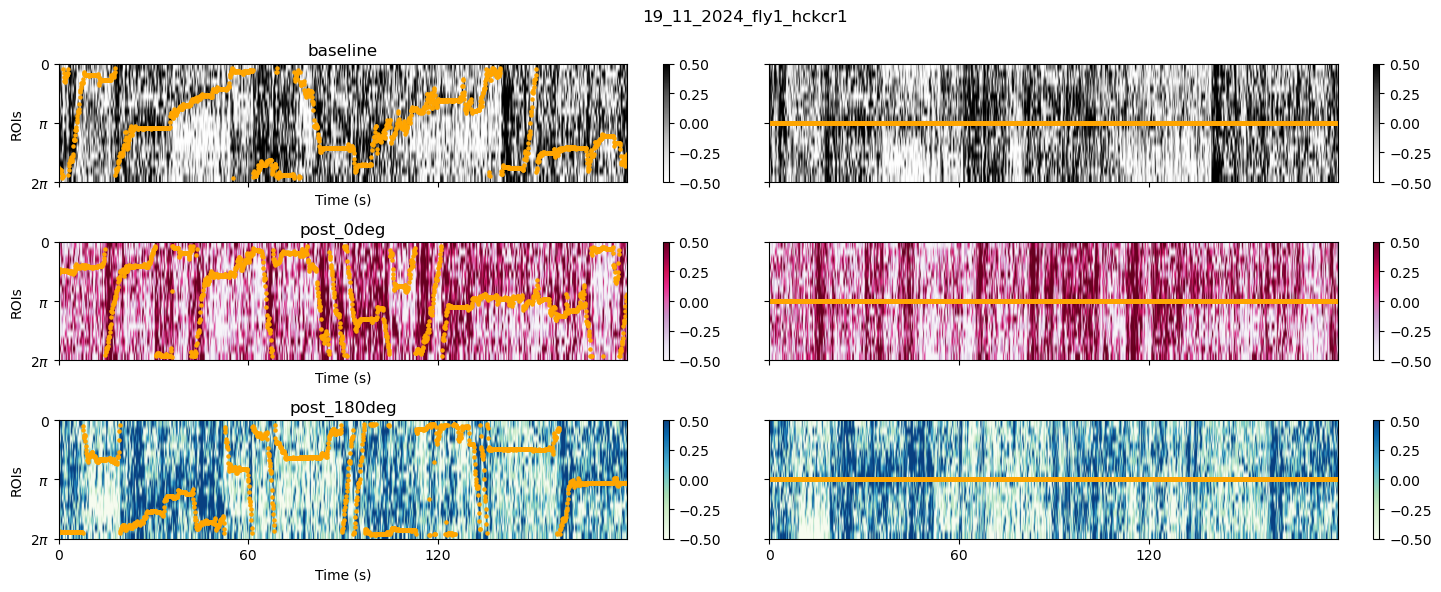

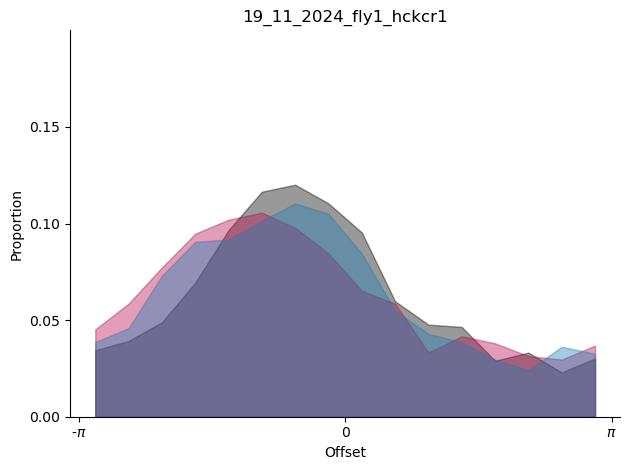

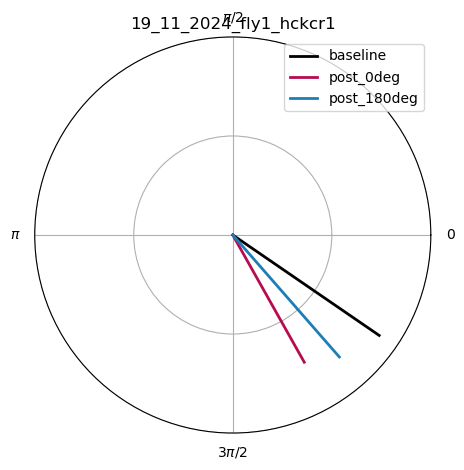

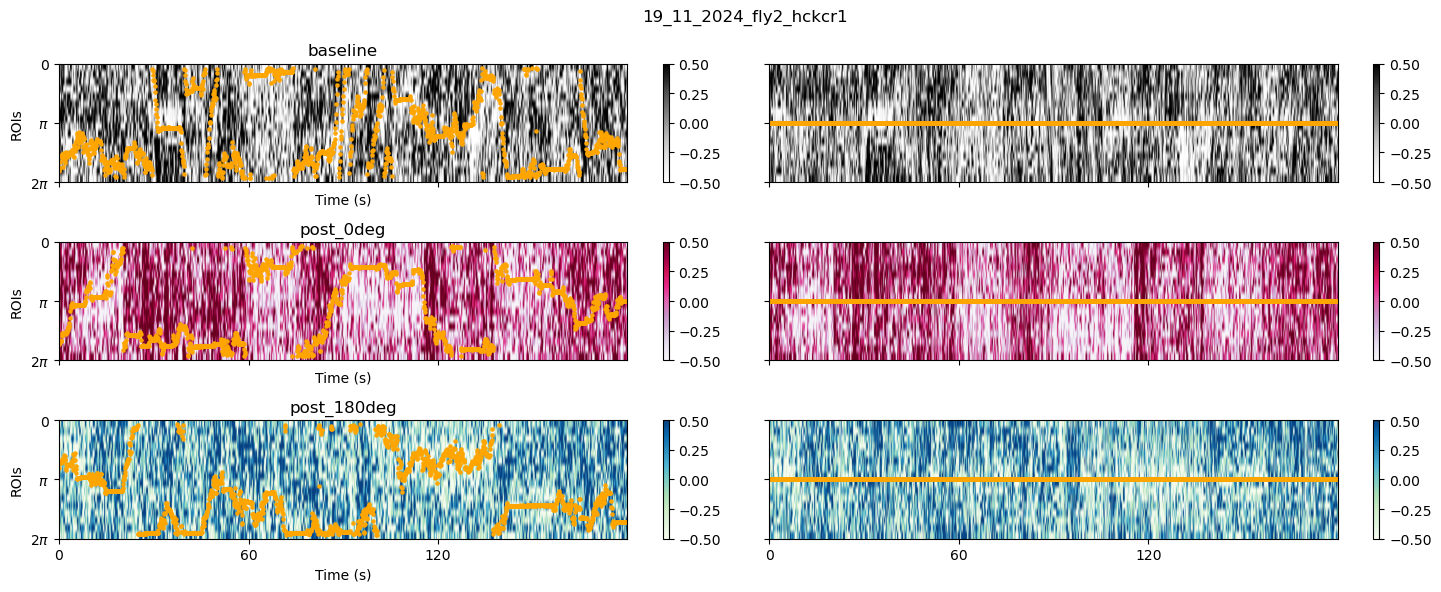

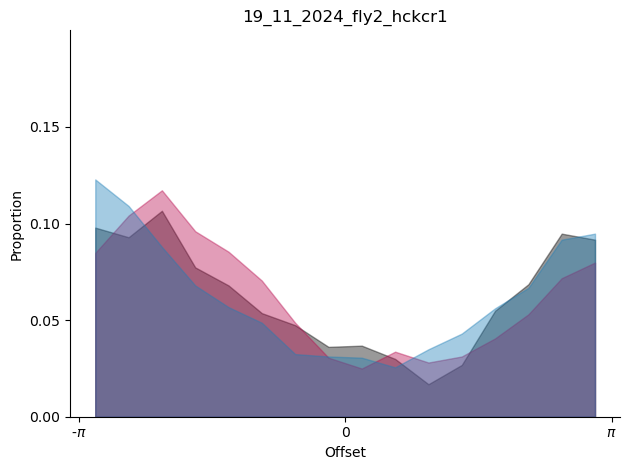

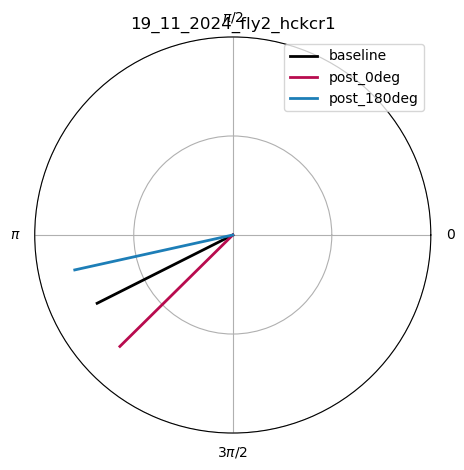

In [24]:
for fly in flies[:2]:

    baseline = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='baseline')]
    post_0deg = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='post_0deg')]
    post_180deg = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='post_180deg')]
    
    if baseline.shape[0]>0 and post_0deg.shape[0]>0 and post_180deg.shape[0]>0:

        ts_dict = {'fly': fly,
                'baseline': nmp.session.GetTS(load_row(baseline.iloc[0])),
                'post_0deg': nmp.session.GetTS(load_row(post_0deg.iloc[0])),
                'post_180deg': nmp.session.GetTS(load_row(post_180deg.iloc[0]))}

        fig, ax = plot_sess_heatmaps(ts_dict)
        (fig_hist, ax_hist), (fig_polar, ax_polar) = plot_sess_histograms(ts_dict)
